In [1]:
# Import necessary libraries
import os
import random
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image


import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split


Matplotlib created a temporary cache directory at /tmp/matplotlib-kfqeacyr because the default path (/gpfs/home/agarwv03/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Set the data path
data_path = "/gpfs/scratch/agarwv03/10_odor_dataset"

In [3]:
class OdorGlomeruliDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        # Dynamically get mouse folders
        mouse_folders = sorted(os.listdir(root_dir))
        
        # Dynamically get odorant folders from the first mouse folder
        first_mouse_dir = os.path.join(root_dir, mouse_folders[0])
        odorant_folders = sorted(os.listdir(first_mouse_dir))
        odorant_labels = {odor: idx for idx, odor in enumerate(odorant_folders)}

        for mouse in mouse_folders:
            mouse_path = os.path.join(root_dir, mouse)
            for odorant in odorant_folders:
                odor_path = os.path.join(mouse_path, odorant)
                images = sorted(os.listdir(odor_path))
                for img_name in images:
                    img_path = os.path.join(odor_path, img_name)
                    label = odorant_labels[odorant]
                    self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, odor_label = self.data[idx]
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return odor_label, image


In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


1952_mouse | Odorant '2_3_pentanedione': Mean=0.2955, Std=0.2011, Min=0.0000, Max=1.0000
1952_mouse | Odorant '2_4_dimethyl_acetophenone': Mean=0.2500, Std=0.1875, Min=0.0000, Max=1.0000
1952_mouse | Odorant '2_ethyl_butyric_acid': Mean=0.2648, Std=0.2046, Min=0.0000, Max=1.0000
1952_mouse | Odorant '2_methyl_butyraldehyde': Mean=0.2925, Std=0.2130, Min=0.0000, Max=1.0000
1952_mouse | Odorant '33_dimethyl_butyric_acid': Mean=0.2537, Std=0.2022, Min=0.0000, Max=1.0000
1952_mouse | Odorant '3_methylvaleric_acid': Mean=0.2310, Std=0.1964, Min=0.0000, Max=1.0000
1952_mouse | Odorant '4_heptanone': Mean=0.2344, Std=0.1935, Min=0.0000, Max=1.0000
1952_mouse | Odorant 'acetic_acid': Mean=0.3365, Std=0.2055, Min=0.0000, Max=1.0000
1952_mouse | Odorant 'gerinol': Mean=0.3207, Std=0.2030, Min=0.0000, Max=1.0000
1952_mouse | Odorant 'm_anisaldehyde': Mean=0.2998, Std=0.1949, Min=0.0000, Max=1.0000
1952_mouse | Odorant 'n_methyl_piperdine': Mean=0.2825, Std=0.2111, Min=0.0000, Max=1.0000
1953_mous

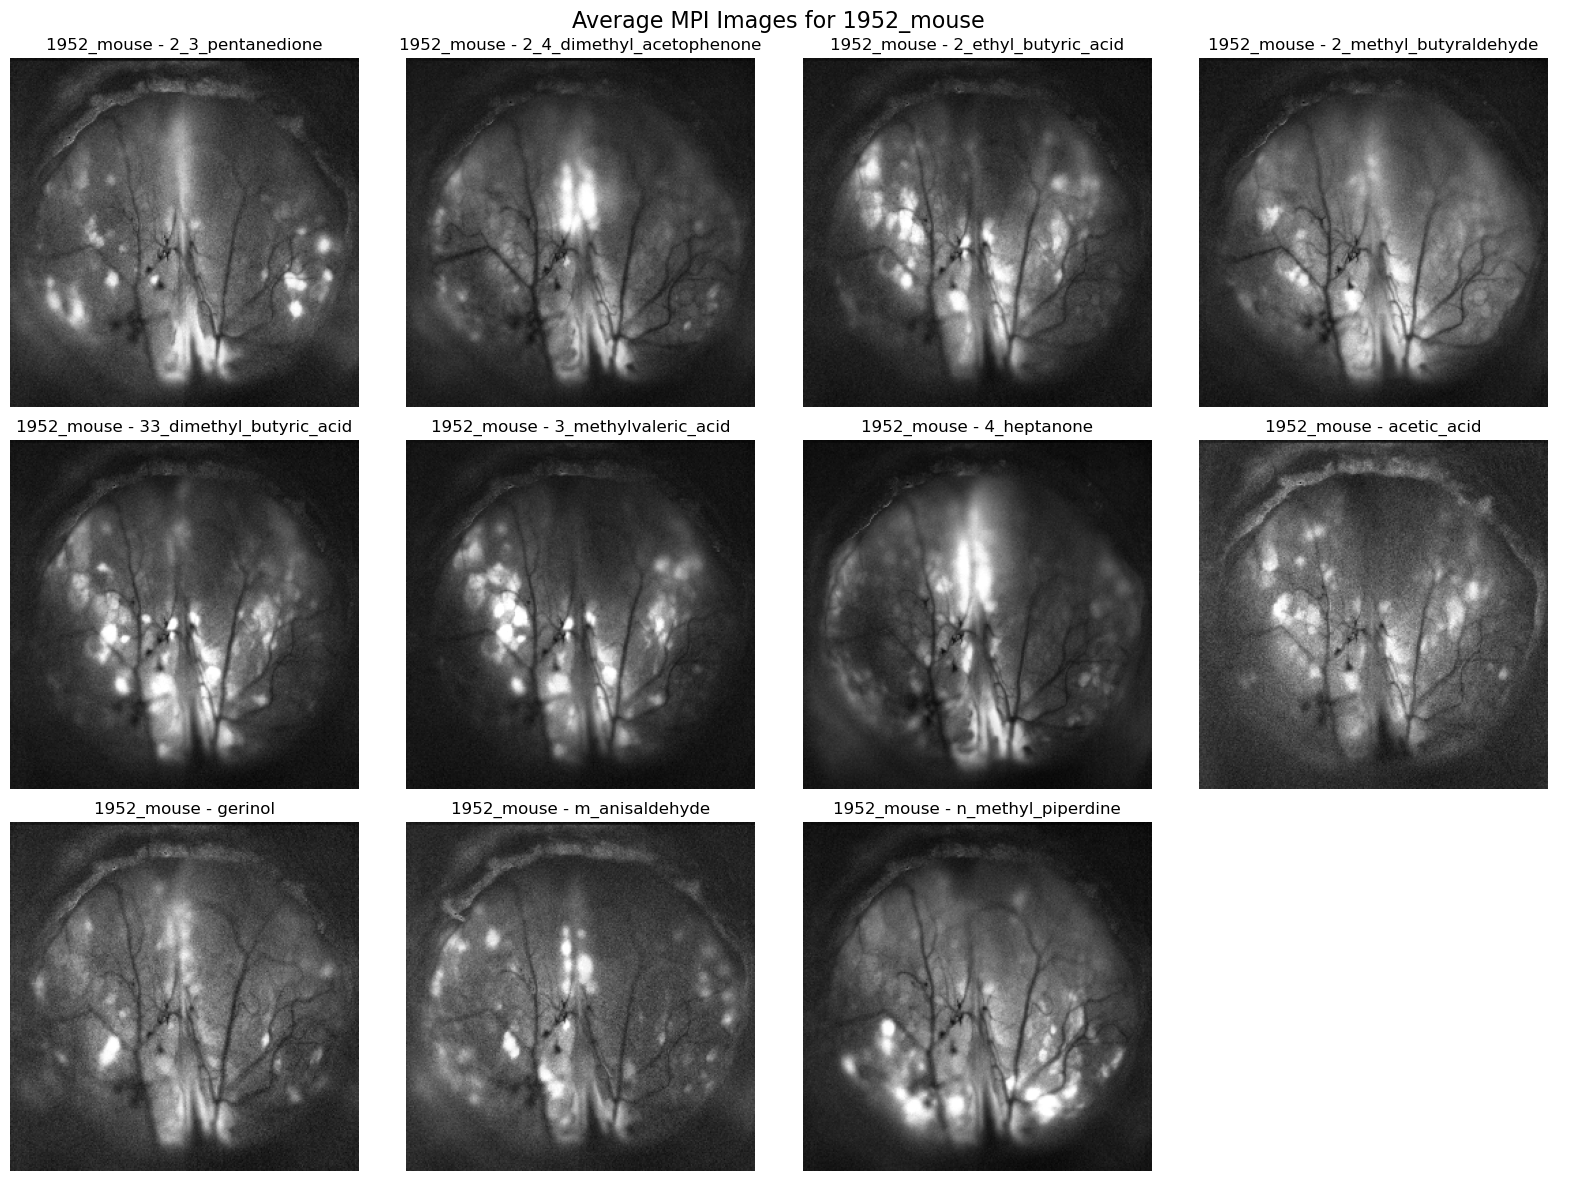

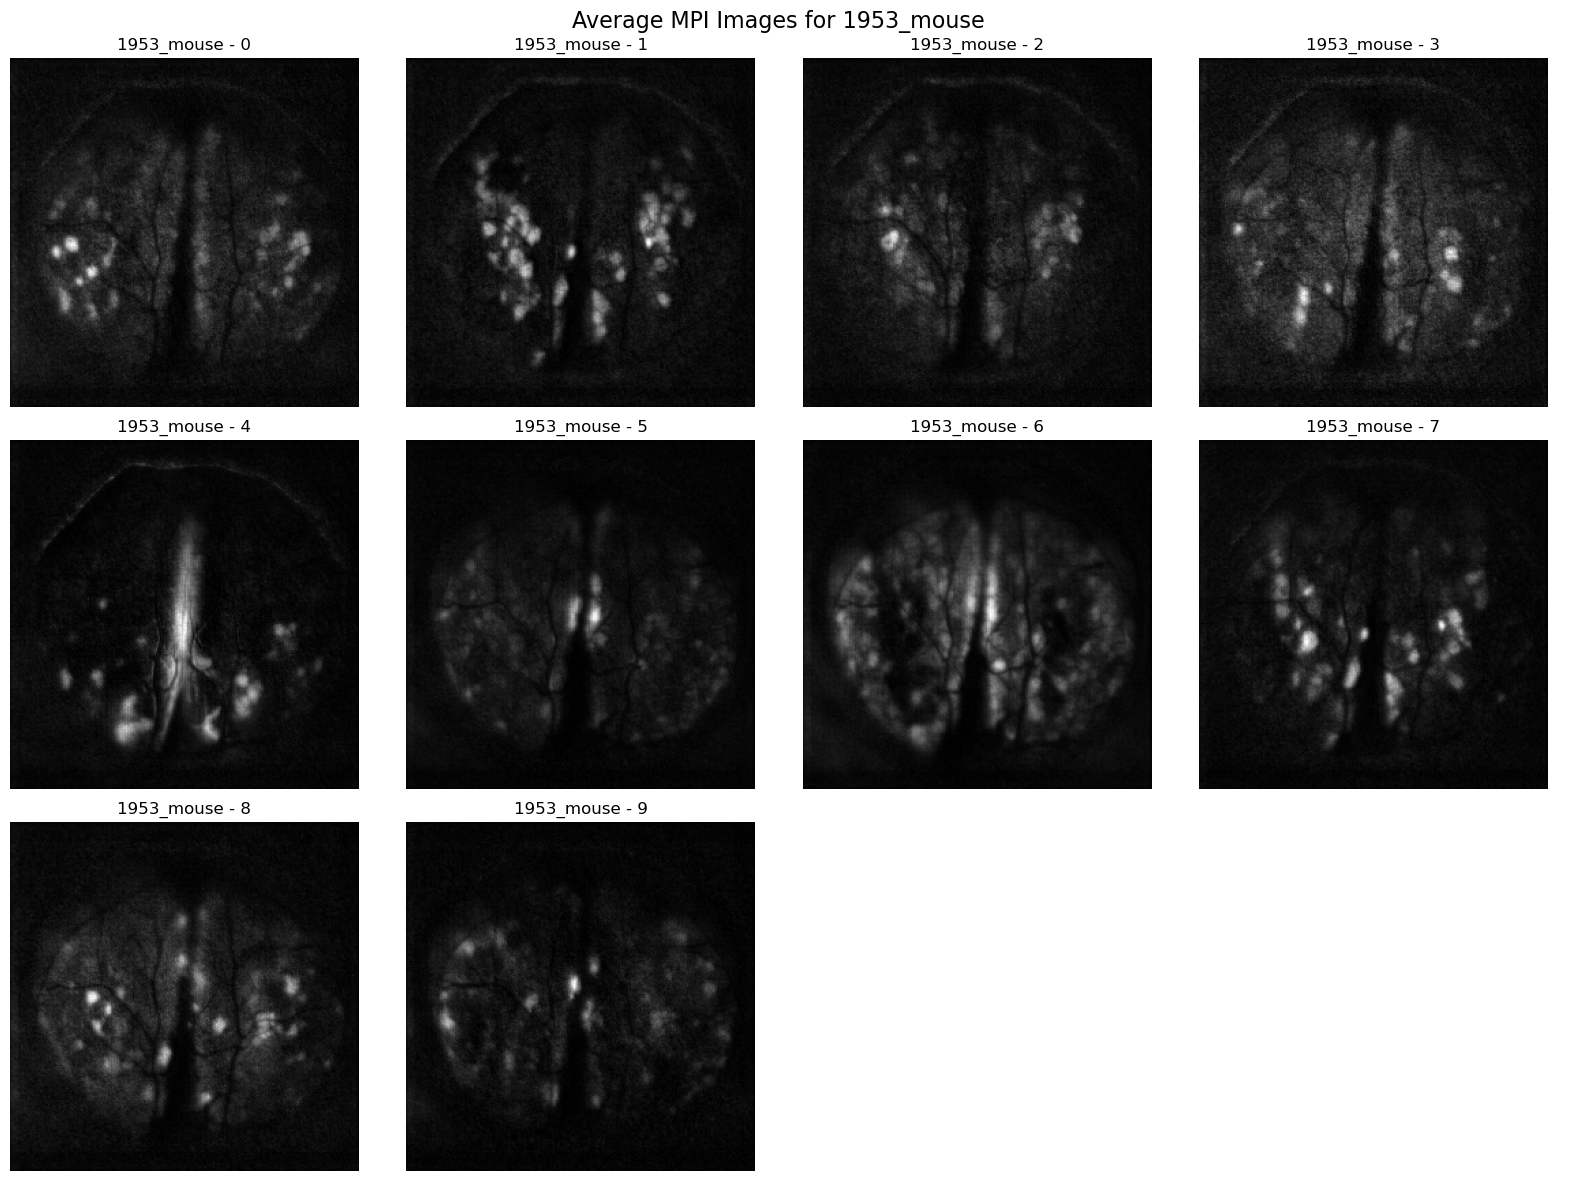

In [5]:

# Prepare mouse folders dynamically
mouse_folders = sorted(os.listdir(data_path))
odorant_stats = {}

for mouse in mouse_folders:
    mouse_path = os.path.join(data_path, mouse)
    odorant_folders = sorted(os.listdir(mouse_path))

    odorant_images = {odor: [] for odor in odorant_folders}

    # Load images
    for odorant in odorant_folders:
        odor_path = os.path.join(mouse_path, odorant)
        images = sorted(os.listdir(odor_path))

        for img_name in images:
            img_path = os.path.join(odor_path, img_name)
            image = Image.open(img_path).convert('L')
            image = transform(image).squeeze(0).numpy()
            odorant_images[odorant].append(image)

    # Compute stats per odorant clearly
    odorant_stats[mouse] = {}
    for odorant, images in odorant_images.items():
        images_array = np.stack(images)

        mean_val = images_array.mean()
        std_val = images_array.std()
        min_val = images_array.min()
        max_val = images_array.max()

        avg_image = images_array.mean(axis=0)

        odorant_stats[mouse][odorant] = {
            "mean": mean_val,
            "std": std_val,
            "min": min_val,
            "max": max_val,
            "avg_image": avg_image
        }

        print(f"{mouse} | Odorant '{odorant}': Mean={mean_val:.4f}, Std={std_val:.4f}, Min={min_val:.4f}, Max={max_val:.4f}")

# Clearly visualize average MPI images mouse-wise
for mouse in mouse_folders:
    odorants = sorted(odorant_stats[mouse].keys())
    num_odorants = len(odorants)
    
    cols = 4
    rows = (num_odorants + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    axes = axes.flatten()

    for idx, odorant in enumerate(odorants):
        ax = axes[idx]
        avg_img = odorant_stats[mouse][odorant]["avg_image"]
        ax.imshow(avg_img, cmap='gray')
        ax.set_title(f"{mouse} - {odorant}")
        ax.axis('off')

    # Hide unused subplots
    for idx in range(num_odorants, len(axes)):
        axes[idx].axis('off')

    plt.suptitle(f"Average MPI Images for {mouse}", fontsize=16)
    plt.tight_layout()
    plt.show()


#### lets start with - within mouse MINE appraoch 

In [6]:
class MINEWithinMouseDataset(Dataset):
    def __init__(self, root_dir, mouse_name, transform=None):
        self.transform = transform
        mouse_path = os.path.join(root_dir, mouse_name)
        self.data = []
        
        odorant_folders = sorted(os.listdir(mouse_path))
        self.odorant_labels = {odor: idx for idx, odor in enumerate(odorant_folders)}
        self.label_to_images = {idx: [] for idx in range(len(odorant_folders))}
        
        for odorant in odorant_folders:
            odor_path = os.path.join(mouse_path, odorant)
            images = sorted(os.listdir(odor_path))
            label = self.odorant_labels[odorant]
            
            for img_name in images:
                img_path = os.path.join(odor_path, img_name)
                self.label_to_images[label].append(img_path)
                self.data.append((img_path, label))
                
        self.labels = list(self.label_to_images.keys())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Joint pair
        img_path, odor_label = self.data[idx]
        joint_image = Image.open(img_path).convert('L')
        
        if self.transform:
            joint_image = self.transform(joint_image)
        
        # Marginal pair: image from random incorrect label
        random_label = odor_label
        while random_label == odor_label:
            random_label = random.choice(self.labels)
        
        marginal_img_path = random.choice(self.label_to_images[random_label])
        marginal_image = Image.open(marginal_img_path).convert('L')
        
        if self.transform:
            marginal_image = self.transform(marginal_image)

        return odor_label, joint_image, marginal_image


In [7]:

# Dynamically detect all mouse folders
mouse_folders = sorted(os.listdir(data_path))
print("Detected mouse folders:", mouse_folders)

# Now instantiate dataset clearly for each mouse separately:
datasets = {}
loaders = {}

for mouse in mouse_folders:
    dataset = MINEWithinMouseDataset(root_dir=data_path, mouse_name=mouse, transform=transform)
    loader = DataLoader(dataset, batch_size=8, shuffle=True)
    
    datasets[mouse] = dataset
    loaders[mouse] = loader
    print(f"{mouse}: {len(dataset)} samples loaded.")

# Quick verification clearly for one mouse
test_mouse = mouse_folders[1]
print(f"\nChecking data loader clearly for {test_mouse}:")

for odor_label, joint_img, marginal_img in loaders[test_mouse]:
    print("Odor labels shape:", odor_label.shape)
    print("Joint images shape:", joint_img.shape)
    print("Marginal images shape:", marginal_img.shape)
    break


Detected mouse folders: ['1952_mouse', '1953_mouse']
1952_mouse: 121 samples loaded.
1953_mouse: 500 samples loaded.

Checking data loader clearly for 1953_mouse:
Odor labels shape: torch.Size([8])
Joint images shape: torch.Size([8, 1, 256, 256])
Marginal images shape: torch.Size([8, 1, 256, 256])


In [8]:
class RobustCriticCNN(nn.Module):
    def __init__(self, num_odors=10, dropout_p=0.2):
        super(RobustCriticCNN, self).__init__()

        # CNN feature extractor
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x128
            nn.Dropout2d(dropout_p),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64
            nn.Dropout2d(dropout_p),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32
            nn.Dropout2d(dropout_p),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),  # 1x1
        )

        # Odor label embedding
        self.label_embedding = nn.Sequential(
            nn.Embedding(num_odors, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(512 + 128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(64, 1)
        )

    def forward(self, odor_labels, images):
        img_feat = self.cnn_layers(images).view(images.size(0), -1)  # [batch,512]
        label_feat = self.label_embedding(odor_labels)               # [batch,128]

        combined = torch.cat([img_feat, label_feat], dim=1)          # [batch,640]
        output = self.fc(combined)                                   # [batch,1]

        return output


In [9]:
# Quick verification code
critic_model = RobustCriticCNN(num_odors=11)

dummy_labels = torch.randint(0, 11, (8,))           # batch size = 32
dummy_images = torch.randn(8, 1, 256, 256)          # batch size = 32, image shape = [1,256,256]

output = critic_model(dummy_labels, dummy_images)
print("Output shape:", output.shape)


Output shape: torch.Size([8, 1])


In [10]:
# def f_divergence_loss(critic, odor_labels, joint_images, marginal_images):

def dv_loss(critic, odor_labels, joint_images, marginal_images):
    joint_scores = critic(odor_labels, joint_images)
    marginal_scores = critic(odor_labels, marginal_images)
    
    loss = -(torch.mean(joint_scores) - torch.mean(torch.exp(marginal_scores - 1)))
    mi_estimation = -loss.item()

    return loss, mi_estimation


In [14]:
'''
def dv_loss(critic, odor_labels, joint_images, marginal_images):
    joint_scores = critic(odor_labels, joint_images)            # shape: [batch, 1]
    marginal_scores = critic(odor_labels, marginal_images)      # shape: [batch, 1]

    # DV Mutual Information estimation clearly:
    mi_estimation = torch.mean(joint_scores) - torch.log(torch.mean(torch.exp(marginal_scores)))
    
    # Loss is negative MI clearly (because we maximize MI)
    loss = -mi_estimation
    
    return loss, mi_estimation.item()
'''

In [11]:
# Initialize model
critic_model = RobustCriticCNN(num_odors=10)

# Dummy inputs clearly for quick verification
dummy_labels = torch.randint(0, 11, (8,))
joint_images = torch.randn(8, 1, 256, 256)
marginal_images = torch.randn(8, 1, 256, 256)

loss, mi_estimate = dv_loss(critic_model, dummy_labels, joint_images, marginal_images)

print(f"DV Loss: {loss.item():.4f}, MI Estimate: {mi_estimate:.4f}")


DV Loss: 0.6924, MI Estimate: -0.6924


In [12]:
def odorant_wise_split(dataset, train_trials_per_odor=35, test_trials_per_odor=15):
    # Organize indices by odorant clearly
    odor_to_indices = {}
    for idx, (label, _, _) in enumerate(dataset):  # Corrected here
        odor_to_indices.setdefault(label, []).append(idx)

    train_indices, test_indices = [], []

    # Split explicitly per odorant
    for odor_label, indices in odor_to_indices.items():
        assert len(indices) >= train_trials_per_odor + test_trials_per_odor, \
            f"Not enough trials for odor {odor_label}"
        random.shuffle(indices)
        train_indices += indices[:train_trials_per_odor]
        test_indices += indices[train_trials_per_odor:train_trials_per_odor + test_trials_per_odor]

    # Create datasets clearly
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    return train_dataset, test_dataset

# Usage example explicitly:
selected_mouse = '1953_mouse'
full_dataset = datasets[selected_mouse]

train_dataset, test_dataset = odorant_wise_split(full_dataset, train_trials_per_odor=35, test_trials_per_odor=15)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 350, Test samples: 150


In [13]:
# Training parameters
num_epochs = 200
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model & optimizer
critic_model = RobustCriticCNN(num_odors=11).to(device)
optimizer = torch.optim.Adam(critic_model.parameters(), lr=learning_rate)

# Trackers
train_mi_history, test_mi_history = [], []

# Training loop explicitly
for epoch in range(num_epochs):
    critic_model.train()
    train_loss, train_mi = 0.0, 0.0

    # Train
    for odor_labels, joint_imgs, marginal_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        odor_labels = odor_labels.to(device)
        joint_imgs = joint_imgs.to(device)
        marginal_imgs = marginal_imgs.to(device)

        optimizer.zero_grad()
        loss, mi_estimate = dv_loss(critic_model, odor_labels, joint_imgs, marginal_imgs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_mi += mi_estimate

    avg_train_loss = train_loss / len(train_loader)
    avg_train_mi = train_mi / len(train_loader)
    train_mi_history.append(avg_train_mi)

    # Evaluate
    critic_model.eval()
    test_loss, test_mi = 0.0, 0.0
    with torch.no_grad():
        for odor_labels, joint_imgs, marginal_imgs in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]"):
            odor_labels = odor_labels.to(device)
            joint_imgs = joint_imgs.to(device)
            marginal_imgs = marginal_imgs.to(device)

            loss, mi_estimate = dv_loss(critic_model, odor_labels, joint_imgs, marginal_imgs)
            test_loss += loss.item()
            test_mi += mi_estimate

    avg_test_loss = test_loss / len(test_loader)
    avg_test_mi = test_mi / len(test_loader)
    test_mi_history.append(avg_test_mi)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train MI: {avg_train_mi:.4f}, Test MI: {avg_test_mi:.4f}")

print("Training complete.")


Epoch 1/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.60it/s]


Epoch [1/200] - Train MI: -0.5692, Test MI: -0.3731


Epoch 2/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.78it/s]


Epoch [2/200] - Train MI: -0.5156, Test MI: -0.3536


Epoch 3/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.67it/s]


Epoch [3/200] - Train MI: -0.4218, Test MI: -0.2909


Epoch 4/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.43it/s]


Epoch [4/200] - Train MI: -0.3573, Test MI: -0.3004


Epoch 5/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.05it/s]


Epoch [5/200] - Train MI: -0.2624, Test MI: -0.2267


Epoch 6/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.84it/s]


Epoch [6/200] - Train MI: -0.2522, Test MI: -0.2183


Epoch 7/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.75it/s]


Epoch [7/200] - Train MI: -0.2087, Test MI: -0.1496


Epoch 8/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.94it/s]


Epoch [8/200] - Train MI: -0.1413, Test MI: -0.1019


Epoch 9/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.05it/s]


Epoch [9/200] - Train MI: -0.1179, Test MI: -0.0673


Epoch 10/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.89it/s]


Epoch [10/200] - Train MI: -0.1073, Test MI: -0.0839


Epoch 11/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.91it/s]


Epoch [11/200] - Train MI: -0.0749, Test MI: -0.0512


Epoch 12/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.00it/s]


Epoch [12/200] - Train MI: -0.0760, Test MI: -0.0525


Epoch 13/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.79it/s]


Epoch [13/200] - Train MI: -0.0409, Test MI: -0.0347


Epoch 14/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.76it/s]


Epoch [14/200] - Train MI: -0.0521, Test MI: -0.0354


Epoch 15/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.95it/s]


Epoch [15/200] - Train MI: -0.0674, Test MI: -0.0349


Epoch 16/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.66it/s]


Epoch [16/200] - Train MI: -0.0520, Test MI: -0.0294


Epoch 17/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.67it/s]


Epoch [17/200] - Train MI: -0.0664, Test MI: -0.0262


Epoch 18/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.95it/s]


Epoch [18/200] - Train MI: -0.0654, Test MI: -0.0335


Epoch 19/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.99it/s]


Epoch [19/200] - Train MI: -0.0423, Test MI: -0.0404


Epoch 20/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.88it/s]


Epoch [20/200] - Train MI: -0.0269, Test MI: -0.0195


Epoch 21/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.81it/s]


Epoch [21/200] - Train MI: -0.0736, Test MI: -0.0049


Epoch 22/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.70it/s]


Epoch [22/200] - Train MI: -0.0422, Test MI: 0.0366


Epoch 23/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.77it/s]


Epoch [23/200] - Train MI: -0.0119, Test MI: 0.0214


Epoch 24/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.70it/s]


Epoch [24/200] - Train MI: -0.0556, Test MI: 0.0316


Epoch 25/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.65it/s]


Epoch [25/200] - Train MI: -0.0229, Test MI: -0.0080


Epoch 26/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.86it/s]


Epoch [26/200] - Train MI: -0.0477, Test MI: 0.0227


Epoch 27/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.98it/s]


Epoch [27/200] - Train MI: -0.0593, Test MI: 0.0146


Epoch 28/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.98it/s]


Epoch [28/200] - Train MI: -0.0148, Test MI: 0.0045


Epoch 29/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.87it/s]


Epoch [29/200] - Train MI: -0.0443, Test MI: 0.0036


Epoch 30/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.88it/s]


Epoch [30/200] - Train MI: 0.0037, Test MI: 0.0382


Epoch 31/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.45it/s]


Epoch [31/200] - Train MI: -0.0163, Test MI: 0.0172


Epoch 32/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.38it/s]


Epoch [32/200] - Train MI: -0.0148, Test MI: 0.0124


Epoch 33/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.56it/s]


Epoch [33/200] - Train MI: -0.0416, Test MI: 0.0180


Epoch 34/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.98it/s]


Epoch [34/200] - Train MI: 0.0042, Test MI: 0.0090


Epoch 35/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.88it/s]


Epoch [35/200] - Train MI: -0.0425, Test MI: 0.0202


Epoch 36/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.66it/s]


Epoch [36/200] - Train MI: -0.0335, Test MI: 0.0223


Epoch 37/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.44it/s]


Epoch [37/200] - Train MI: -0.0415, Test MI: 0.0063


Epoch 38/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.76it/s]


Epoch [38/200] - Train MI: -0.0396, Test MI: 0.0133


Epoch 39/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.52it/s]


Epoch [39/200] - Train MI: -0.0329, Test MI: 0.0179


Epoch 40/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.76it/s]


Epoch [40/200] - Train MI: -0.0625, Test MI: 0.0341


Epoch 41/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.85it/s]


Epoch [41/200] - Train MI: -0.0281, Test MI: 0.0081


Epoch 42/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.12it/s]


Epoch [42/200] - Train MI: -0.0132, Test MI: 0.0198


Epoch 43/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.92it/s]


Epoch [43/200] - Train MI: -0.0125, Test MI: 0.0071


Epoch 44/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.02it/s]


Epoch [44/200] - Train MI: 0.0036, Test MI: 0.0281


Epoch 45/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.22it/s]


Epoch [45/200] - Train MI: -0.0403, Test MI: 0.0324


Epoch 46/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.82it/s]


Epoch [46/200] - Train MI: -0.0239, Test MI: 0.0248


Epoch 47/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.34it/s]


Epoch [47/200] - Train MI: -0.0139, Test MI: 0.0256


Epoch 48/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.60it/s]


Epoch [48/200] - Train MI: -0.0279, Test MI: 0.0168


Epoch 49/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.63it/s]


Epoch [49/200] - Train MI: 0.0135, Test MI: 0.0058


Epoch 50/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.33it/s]


Epoch [50/200] - Train MI: 0.0001, Test MI: 0.0102


Epoch 51/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.99it/s]


Epoch [51/200] - Train MI: -0.0151, Test MI: 0.0146


Epoch 52/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.65it/s]


Epoch [52/200] - Train MI: -0.0107, Test MI: 0.0152


Epoch 53/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.55it/s]


Epoch [53/200] - Train MI: -0.0094, Test MI: 0.0275


Epoch 54/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 33.76it/s]


Epoch [54/200] - Train MI: -0.0180, Test MI: 0.0343


Epoch 55/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 33.96it/s]


Epoch [55/200] - Train MI: -0.0551, Test MI: 0.0254


Epoch 56/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 33.39it/s]


Epoch [56/200] - Train MI: -0.0081, Test MI: 0.0260


Epoch 57/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.04it/s]


Epoch [57/200] - Train MI: -0.0013, Test MI: 0.0436


Epoch 58/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.32it/s]


Epoch [58/200] - Train MI: 0.0079, Test MI: 0.0519


Epoch 59/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.13it/s]


Epoch [59/200] - Train MI: -0.0222, Test MI: 0.0435


Epoch 60/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.98it/s]


Epoch [60/200] - Train MI: 0.0165, Test MI: 0.0382


Epoch 61/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.25it/s]


Epoch [61/200] - Train MI: -0.0321, Test MI: 0.0336


Epoch 62/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.72it/s]


Epoch [62/200] - Train MI: -0.0183, Test MI: 0.0520


Epoch 63/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.97it/s]


Epoch [63/200] - Train MI: -0.0136, Test MI: 0.0246


Epoch 64/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.09it/s]


Epoch [64/200] - Train MI: -0.0173, Test MI: 0.0322


Epoch 65/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.04it/s]


Epoch [65/200] - Train MI: 0.0002, Test MI: 0.0315


Epoch 66/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.10it/s]


Epoch [66/200] - Train MI: 0.0055, Test MI: 0.0482


Epoch 67/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.21it/s]


Epoch [67/200] - Train MI: -0.0056, Test MI: 0.0234


Epoch 68/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.34it/s]


Epoch [68/200] - Train MI: 0.0087, Test MI: 0.0283


Epoch 69/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.76it/s]


Epoch [69/200] - Train MI: -0.0096, Test MI: 0.0268


Epoch 70/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.74it/s]


Epoch [70/200] - Train MI: 0.0153, Test MI: 0.0439


Epoch 71/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.45it/s]


Epoch [71/200] - Train MI: 0.0217, Test MI: 0.0469


Epoch 72/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.34it/s]


Epoch [72/200] - Train MI: 0.0021, Test MI: 0.0334


Epoch 73/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.30it/s]


Epoch [73/200] - Train MI: 0.0014, Test MI: 0.0577


Epoch 74/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.28it/s]


Epoch [74/200] - Train MI: 0.0051, Test MI: 0.0394


Epoch 75/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.50it/s]


Epoch [75/200] - Train MI: 0.0308, Test MI: 0.0548


Epoch 76/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.19it/s]


Epoch [76/200] - Train MI: -0.0162, Test MI: 0.0261


Epoch 77/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.07it/s]


Epoch [77/200] - Train MI: 0.0319, Test MI: 0.0387


Epoch 78/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.29it/s]


Epoch [78/200] - Train MI: 0.0136, Test MI: 0.0383


Epoch 79/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.58it/s]


Epoch [79/200] - Train MI: 0.0111, Test MI: 0.0566


Epoch 80/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.10it/s]


Epoch [80/200] - Train MI: 0.0093, Test MI: 0.0721


Epoch 81/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.08it/s]


Epoch [81/200] - Train MI: 0.0016, Test MI: 0.0599


Epoch 82/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.11it/s]


Epoch [82/200] - Train MI: 0.0144, Test MI: 0.0825


Epoch 83/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.15it/s]


Epoch [83/200] - Train MI: 0.0271, Test MI: 0.0550


Epoch 84/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.18it/s]


Epoch [84/200] - Train MI: 0.0001, Test MI: 0.0614


Epoch 85/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.20it/s]


Epoch [85/200] - Train MI: 0.0247, Test MI: 0.0665


Epoch 86/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.98it/s]


Epoch [86/200] - Train MI: 0.0091, Test MI: 0.0550


Epoch 87/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.26it/s]


Epoch [87/200] - Train MI: 0.0033, Test MI: 0.0408


Epoch 88/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.06it/s]


Epoch [88/200] - Train MI: -0.0111, Test MI: 0.0556


Epoch 89/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.94it/s]


Epoch [89/200] - Train MI: -0.0033, Test MI: 0.0604


Epoch 90/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.03it/s]


Epoch [90/200] - Train MI: 0.0094, Test MI: 0.0532


Epoch 91/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.61it/s]


Epoch [91/200] - Train MI: 0.0245, Test MI: 0.0536


Epoch 92/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.56it/s]


Epoch [92/200] - Train MI: 0.0114, Test MI: 0.0633


Epoch 93/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.98it/s]


Epoch [93/200] - Train MI: 0.0142, Test MI: 0.0588


Epoch 94/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.51it/s]


Epoch [94/200] - Train MI: 0.0173, Test MI: 0.0621


Epoch 95/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.28it/s]


Epoch [95/200] - Train MI: 0.0179, Test MI: 0.0662


Epoch 96/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.23it/s]


Epoch [96/200] - Train MI: 0.0021, Test MI: 0.0418


Epoch 97/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.45it/s]


Epoch [97/200] - Train MI: 0.0170, Test MI: 0.0590


Epoch 98/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.44it/s]


Epoch [98/200] - Train MI: -0.0238, Test MI: 0.0547


Epoch 99/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.87it/s]


Epoch [99/200] - Train MI: 0.0074, Test MI: 0.0466


Epoch 100/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.06it/s]


Epoch [100/200] - Train MI: 0.0172, Test MI: 0.0659


Epoch 101/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.33it/s]


Epoch [101/200] - Train MI: 0.0176, Test MI: 0.0726


Epoch 102/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.07it/s]


Epoch [102/200] - Train MI: 0.0222, Test MI: 0.0698


Epoch 103/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.97it/s]


Epoch [103/200] - Train MI: 0.0008, Test MI: 0.0693


Epoch 104/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.37it/s]


Epoch [104/200] - Train MI: 0.0195, Test MI: 0.0647


Epoch 105/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.91it/s]


Epoch [105/200] - Train MI: 0.0024, Test MI: 0.0607


Epoch 106/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.17it/s]


Epoch [106/200] - Train MI: -0.0096, Test MI: 0.0632


Epoch 107/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.11it/s]


Epoch [107/200] - Train MI: 0.0351, Test MI: 0.0656


Epoch 108/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.13it/s]


Epoch [108/200] - Train MI: 0.0118, Test MI: 0.0585


Epoch 109/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.87it/s]


Epoch [109/200] - Train MI: 0.0367, Test MI: 0.0794


Epoch 110/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.86it/s]


Epoch [110/200] - Train MI: 0.0155, Test MI: 0.0824


Epoch 111/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.15it/s]


Epoch [111/200] - Train MI: 0.0164, Test MI: 0.0794


Epoch 112/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.12it/s]


Epoch [112/200] - Train MI: 0.0414, Test MI: 0.0699


Epoch 113/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.50it/s]


Epoch [113/200] - Train MI: 0.0307, Test MI: 0.0711


Epoch 114/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.63it/s]


Epoch [114/200] - Train MI: -0.0033, Test MI: 0.0716


Epoch 115/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.69it/s]


Epoch [115/200] - Train MI: -0.0068, Test MI: 0.0649


Epoch 116/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.45it/s]


Epoch [116/200] - Train MI: 0.0370, Test MI: 0.0981


Epoch 117/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.63it/s]


Epoch [117/200] - Train MI: 0.0322, Test MI: 0.0739


Epoch 118/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.07it/s]


Epoch [118/200] - Train MI: -0.0017, Test MI: 0.0880


Epoch 119/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.13it/s]


Epoch [119/200] - Train MI: 0.0305, Test MI: 0.0813


Epoch 120/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.93it/s]


Epoch [120/200] - Train MI: 0.0172, Test MI: 0.0829


Epoch 121/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.47it/s]


Epoch [121/200] - Train MI: 0.0562, Test MI: 0.0659


Epoch 122/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.97it/s]


Epoch [122/200] - Train MI: -0.0084, Test MI: 0.0549


Epoch 123/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.17it/s]


Epoch [123/200] - Train MI: 0.0328, Test MI: 0.0812


Epoch 124/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.71it/s]


Epoch [124/200] - Train MI: 0.0342, Test MI: 0.0667


Epoch 125/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.14it/s]


Epoch [125/200] - Train MI: 0.0444, Test MI: 0.0734


Epoch 126/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.55it/s]


Epoch [126/200] - Train MI: 0.0236, Test MI: 0.0868


Epoch 127/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.21it/s]


Epoch [127/200] - Train MI: 0.0381, Test MI: 0.0830


Epoch 128/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.66it/s]


Epoch [128/200] - Train MI: 0.0383, Test MI: 0.0834


Epoch 129/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.76it/s]


Epoch [129/200] - Train MI: -0.0079, Test MI: 0.0776


Epoch 130/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.55it/s]


Epoch [130/200] - Train MI: 0.0366, Test MI: 0.0692


Epoch 131/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.78it/s]


Epoch [131/200] - Train MI: 0.0224, Test MI: 0.0740


Epoch 132/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.86it/s]


Epoch [132/200] - Train MI: 0.0388, Test MI: 0.0964


Epoch 133/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.57it/s]


Epoch [133/200] - Train MI: 0.0207, Test MI: 0.0923


Epoch 134/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.99it/s]


Epoch [134/200] - Train MI: 0.0035, Test MI: 0.0774


Epoch 135/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.54it/s]


Epoch [135/200] - Train MI: 0.0310, Test MI: 0.0773


Epoch 136/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.46it/s]


Epoch [136/200] - Train MI: 0.0310, Test MI: 0.0806


Epoch 137/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.52it/s]


Epoch [137/200] - Train MI: 0.0230, Test MI: 0.0643


Epoch 138/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.70it/s]


Epoch [138/200] - Train MI: 0.0436, Test MI: 0.0733


Epoch 139/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.60it/s]


Epoch [139/200] - Train MI: 0.0424, Test MI: 0.0587


Epoch 140/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.76it/s]


Epoch [140/200] - Train MI: 0.0176, Test MI: 0.1052


Epoch 141/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.80it/s]


Epoch [141/200] - Train MI: 0.0464, Test MI: 0.0778


Epoch 142/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.81it/s]


Epoch [142/200] - Train MI: 0.0324, Test MI: 0.0981


Epoch 143/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.77it/s]


Epoch [143/200] - Train MI: 0.0325, Test MI: 0.0867


Epoch 144/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.03it/s]


Epoch [144/200] - Train MI: 0.0287, Test MI: 0.0890


Epoch 145/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.73it/s]


Epoch [145/200] - Train MI: 0.0677, Test MI: 0.0928


Epoch 146/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.51it/s]


Epoch [146/200] - Train MI: 0.0379, Test MI: 0.1076


Epoch 147/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.50it/s]


Epoch [147/200] - Train MI: 0.0476, Test MI: 0.0850


Epoch 148/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.56it/s]


Epoch [148/200] - Train MI: 0.0440, Test MI: 0.0952


Epoch 149/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.21it/s]


Epoch [149/200] - Train MI: 0.0399, Test MI: 0.1078


Epoch 150/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.51it/s]


Epoch [150/200] - Train MI: 0.0694, Test MI: 0.0993


Epoch 151/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.74it/s]


Epoch [151/200] - Train MI: 0.0739, Test MI: 0.0967


Epoch 152/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.44it/s]


Epoch [152/200] - Train MI: 0.0134, Test MI: 0.0651


Epoch 153/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.38it/s]


Epoch [153/200] - Train MI: 0.0447, Test MI: 0.0998


Epoch 154/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.75it/s]


Epoch [154/200] - Train MI: 0.0561, Test MI: 0.1160


Epoch 155/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.82it/s]


Epoch [155/200] - Train MI: 0.0470, Test MI: 0.1179


Epoch 156/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.72it/s]


Epoch [156/200] - Train MI: 0.0587, Test MI: 0.0987


Epoch 157/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.04it/s]


Epoch [157/200] - Train MI: 0.0582, Test MI: 0.0989


Epoch 158/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.66it/s]


Epoch [158/200] - Train MI: 0.0323, Test MI: 0.1002


Epoch 159/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.77it/s]


Epoch [159/200] - Train MI: 0.0259, Test MI: 0.1349


Epoch 160/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.02it/s]


Epoch [160/200] - Train MI: 0.0567, Test MI: 0.1073


Epoch 161/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.72it/s]


Epoch [161/200] - Train MI: 0.0584, Test MI: 0.1288


Epoch 162/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.64it/s]


Epoch [162/200] - Train MI: 0.0321, Test MI: 0.1091


Epoch 163/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.93it/s]


Epoch [163/200] - Train MI: 0.0507, Test MI: 0.1107


Epoch 164/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.83it/s]


Epoch [164/200] - Train MI: 0.0730, Test MI: 0.1128


Epoch 165/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.88it/s]


Epoch [165/200] - Train MI: 0.0731, Test MI: 0.1090


Epoch 166/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.73it/s]


Epoch [166/200] - Train MI: 0.0443, Test MI: 0.1020


Epoch 167/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.79it/s]


Epoch [167/200] - Train MI: 0.0798, Test MI: 0.1069


Epoch 168/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.99it/s]


Epoch [168/200] - Train MI: 0.0520, Test MI: 0.1403


Epoch 169/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.41it/s]


Epoch [169/200] - Train MI: 0.0625, Test MI: 0.0979


Epoch 170/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.94it/s]


Epoch [170/200] - Train MI: 0.0604, Test MI: 0.1097


Epoch 171/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.87it/s]


Epoch [171/200] - Train MI: 0.0661, Test MI: 0.1102


Epoch 172/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.89it/s]


Epoch [172/200] - Train MI: 0.0459, Test MI: 0.1022


Epoch 173/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.72it/s]


Epoch [173/200] - Train MI: 0.0467, Test MI: 0.0893


Epoch 174/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.89it/s]


Epoch [174/200] - Train MI: 0.0693, Test MI: 0.1469


Epoch 175/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.86it/s]


Epoch [175/200] - Train MI: 0.0593, Test MI: 0.1101


Epoch 176/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.99it/s]


Epoch [176/200] - Train MI: 0.0809, Test MI: 0.1156


Epoch 177/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.73it/s]


Epoch [177/200] - Train MI: 0.0675, Test MI: 0.1112


Epoch 178/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.82it/s]


Epoch [178/200] - Train MI: 0.0426, Test MI: 0.1083


Epoch 179/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.53it/s]


Epoch [179/200] - Train MI: 0.0303, Test MI: 0.1124


Epoch 180/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.91it/s]


Epoch [180/200] - Train MI: 0.0781, Test MI: 0.1148


Epoch 181/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.80it/s]


Epoch [181/200] - Train MI: 0.0529, Test MI: 0.1315


Epoch 182/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.33it/s]


Epoch [182/200] - Train MI: 0.0542, Test MI: 0.1236


Epoch 183/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.16it/s]


Epoch [183/200] - Train MI: 0.0594, Test MI: 0.1186


Epoch 184/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.63it/s]


Epoch [184/200] - Train MI: 0.0829, Test MI: 0.0933


Epoch 185/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.58it/s]


Epoch [185/200] - Train MI: 0.0807, Test MI: 0.1136


Epoch 186/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.69it/s]


Epoch [186/200] - Train MI: 0.0736, Test MI: 0.1386


Epoch 187/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.68it/s]


Epoch [187/200] - Train MI: 0.0428, Test MI: 0.1338


Epoch 188/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.76it/s]


Epoch [188/200] - Train MI: 0.0816, Test MI: 0.1353


Epoch 189/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.92it/s]


Epoch [189/200] - Train MI: 0.0493, Test MI: 0.1329


Epoch 190/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.71it/s]


Epoch [190/200] - Train MI: 0.0752, Test MI: 0.1208


Epoch 191/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.36it/s]


Epoch [191/200] - Train MI: 0.0450, Test MI: 0.1480


Epoch 192/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.66it/s]


Epoch [192/200] - Train MI: 0.0585, Test MI: 0.1468


Epoch 193/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.58it/s]


Epoch [193/200] - Train MI: 0.0432, Test MI: 0.1336


Epoch 194/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.54it/s]


Epoch [194/200] - Train MI: 0.0619, Test MI: 0.1491


Epoch 195/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.47it/s]


Epoch [195/200] - Train MI: 0.0571, Test MI: 0.1577


Epoch 196/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.69it/s]


Epoch [196/200] - Train MI: 0.0734, Test MI: 0.1638


Epoch 197/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.67it/s]


Epoch [197/200] - Train MI: 0.1008, Test MI: 0.1374


Epoch 198/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.45it/s]


Epoch [198/200] - Train MI: 0.0922, Test MI: 0.1574


Epoch 199/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.64it/s]


Epoch [199/200] - Train MI: 0.0977, Test MI: 0.1614


Epoch 200/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.56it/s]

Epoch [200/200] - Train MI: 0.1008, Test MI: 0.1336
Training complete.


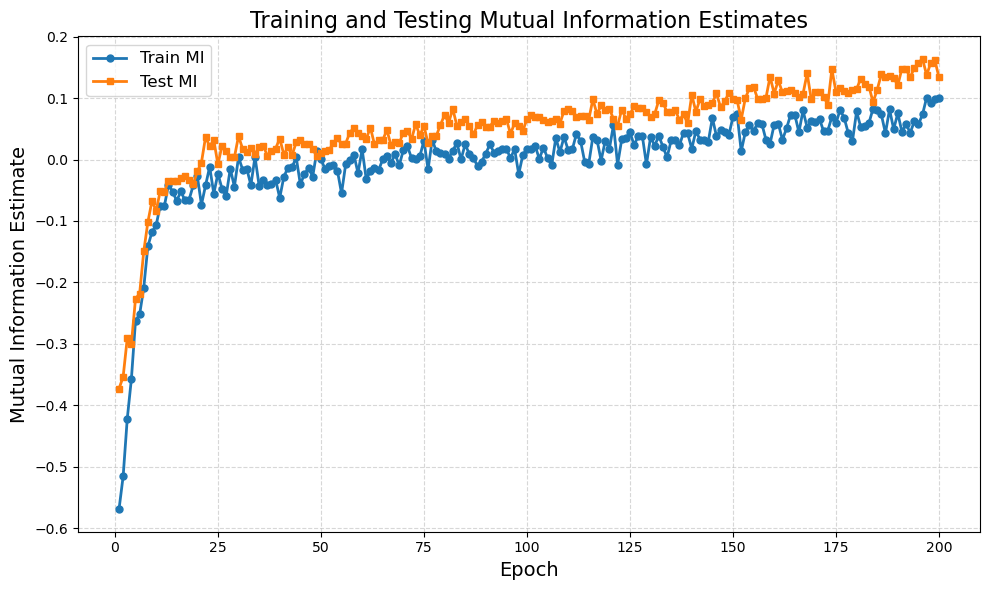

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
epochs = range(1, len(train_mi_history) + 1)

# Plotting Train MI
plt.plot(epochs, train_mi_history, '-o', linewidth=2, markersize=5, label='Train MI')

# Plotting Test MI
plt.plot(epochs, test_mi_history, '-s', linewidth=2, markersize=5, label='Test MI')

# Labels and Title
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Mutual Information Estimate', fontsize=14)
plt.title('Training and Testing Mutual Information Estimates', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)

# Legend explicitly
plt.legend(fontsize=12)

# Clear layout and presentation
plt.tight_layout()

plt.show()


In [15]:
critic_model.eval()

joint_scores, marginal_scores = [], []

with torch.no_grad():
    for odor_labels, joint_imgs, marginal_imgs in test_loader:
        odor_labels = odor_labels.to(device)
        joint_imgs = joint_imgs.to(device)
        marginal_imgs = marginal_imgs.to(device)

        joint_out = critic_model(odor_labels, joint_imgs).cpu().numpy().flatten()
        marginal_out = critic_model(odor_labels, marginal_imgs).cpu().numpy().flatten()

        joint_scores.extend(joint_out)
        marginal_scores.extend(marginal_out)


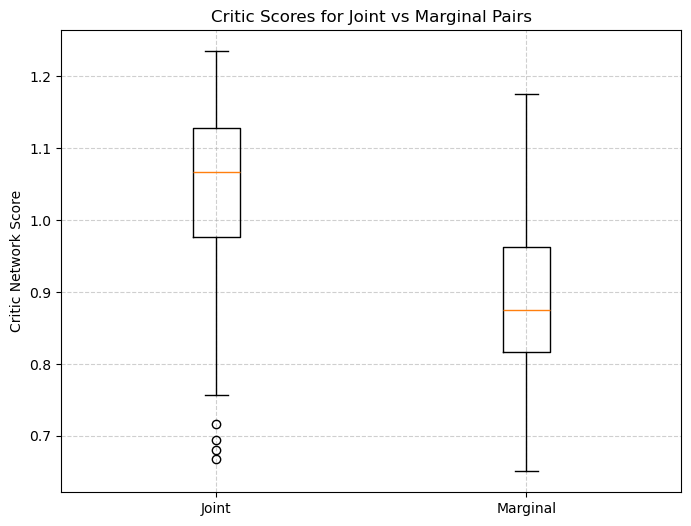

In [16]:
plt.figure(figsize=(8,6))
plt.boxplot([joint_scores, marginal_scores], labels=['Joint', 'Marginal'])
plt.ylabel("Critic Network Score")
plt.title("Critic Scores for Joint vs Marginal Pairs")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


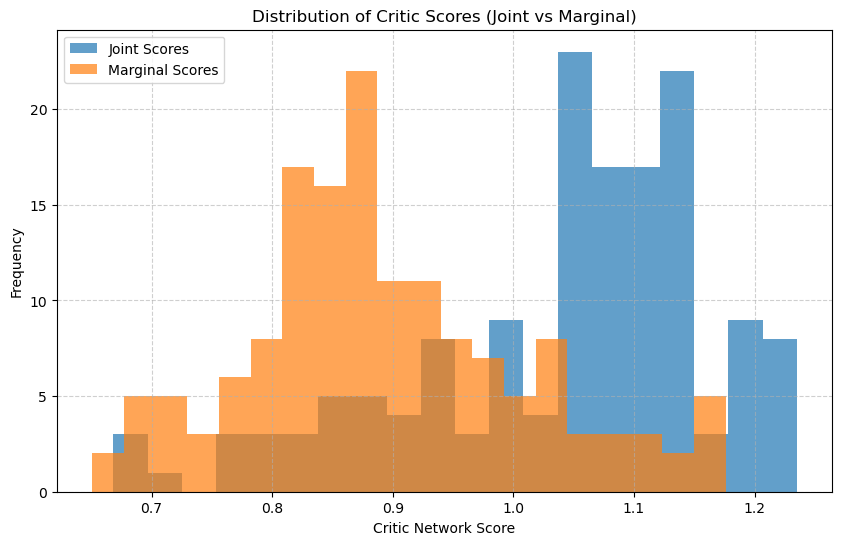

In [17]:
plt.figure(figsize=(10,6))
plt.hist(joint_scores, bins=20, alpha=0.7, label='Joint Scores')
plt.hist(marginal_scores, bins=20, alpha=0.7, label='Marginal Scores')
plt.xlabel("Critic Network Score")
plt.ylabel("Frequency")
plt.title("Distribution of Critic Scores (Joint vs Marginal)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
